This Colab notebook is adapted from DeepLearning. ai / Coursera assignment week 1 Course "Natural Language Processing with Attention Models" from Natural Language Processing Specialization 
- https://www.coursera.org/learn/attention-models-in-nlp/home/welcome
- https://www.coursera.org/specializations/natural-language-processing

# Neural Machine Translation using TRAX and encoder-decoder architecture
- build an English-to-German neural machine translation (NMT) model using Long Short-Term Memory (LSTM) networks with attention.
- Implementing this using just a Recurrent Neural Network (RNN) with LSTMs can work for short to medium length sentences but can result in vanishing gradients for very long sequences.
- To solve this, an attention mechanism allows the decoder to access all relevant parts of the input sentence regardless of its length.
- The model uses a encoder - decoder architecture
- the model generates translations using greedy and Minimum Bayes Risk (MBR) decoding

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd "/content/drive/My Drive/Colab Notebooks/TRAX_translation_encoder_decoder_network"

/content/drive/My Drive/Colab Notebooks/TRAX_translation_encoder_decoder_network


# Installing TRAX

In [4]:
!pip install t5==0.6.2

     |████████████████████████████████| 163kB 6.7MB/s 
     |████████████████████████████████| 1.2MB 6.3MB/s 
     |████████████████████████████████| 2.2MB 10.2MB/s 
     |████████████████████████████████| 3.8MB 36.4MB/s 
     |████████████████████████████████| 3.4MB 37.7MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 368kB 40.1MB/s 
     |████████████████████████████████| 3.3MB 42.2MB/s 
     |████████████████████████████████| 870kB 34.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=2f8c60ca81b2924fb66e97a480e01c11279c286a5efe432ee0f5cd3690ff3a67
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [5]:
!pip install -q -U trax==1.3.4

     |████████████████████████████████| 368kB 6.6MB/s 
     |████████████████████████████████| 1.5MB 40.7MB/s 
     |████████████████████████████████| 655kB 37.7MB/s 
     |████████████████████████████████| 706kB 38.9MB/s 
     |████████████████████████████████| 358kB 35.9MB/s 
     |████████████████████████████████| 378kB 38.5MB/s 
     |████████████████████████████████| 983kB 39.9MB/s 
     |████████████████████████████████| 194kB 40.0MB/s 
     |████████████████████████████████| 368kB 39.3MB/s 
     |████████████████████████████████| 5.6MB 37.8MB/s 
     |████████████████████████████████| 256kB 40.7MB/s 
ERROR: kfac 0.2.3 has requirement tensorflow-probability==0.8, but you'll have tensorflow-probability 0.7.0 which is incompatible.


# Load packages
- Please note that Trax Numpy is referred to as fastnp while numpy remains as np

In [6]:
from termcolor import colored
import random
import numpy as np
from collections import Counter

import trax
from trax import layers as tl
from trax.fastmath import numpy as fastnp
from trax.supervised import training

!pip list | grep trax

INFO:tensorflow:tokens_length=568 inputs_length=512 targets_length=114 noise_density=0.15 mean_noise_span_length=3.0 


trax                          1.3.4                


# Load Dataset
- English to German translation subset specified as opus/medical which has medical related texts
- you can opt to get other corpus such as the English to German translation dataset from ParaCrawl, a large multi-lingual translation dataset created by the European Union. Both of these datasets are available via Tensorflow Datasets (TFDS) and you can browse through the other available datasets here.
- https://www.tensorflow.org/datasets/catalog/opus
- https://opus.nlpl.eu/

In [7]:
# Get generator function for the training set
# This will download the train dataset if no data_dir is specified.
train_stream_fn = trax.data.TFDS('opus/medical',
                                 data_dir='./data/',
                                 keys=('en', 'de'),
                                 eval_holdout_size=0.01, # 1% for eval
                                 train=True)

# Get generator function for the eval set
eval_stream_fn = trax.data.TFDS('opus/medical',
                                data_dir='./data/',
                                keys=('en', 'de'),
                                eval_holdout_size=0.01, # 1% for eval
                                train=False)

In [8]:
train_stream = train_stream_fn()
print(colored('train data (en, de) tuple:', 'red'), next(train_stream))
print()

eval_stream = eval_stream_fn()
print(colored('eval data (en, de) tuple:', 'red'), next(eval_stream))

train data (en, de) tuple: (b'In the pregnant rat the AUC for calculated free drug at this dose was approximately 18 times the human AUC at a 20 mg dose.\n', b'Bei tr\xc3\xa4chtigen Ratten war die AUC f\xc3\xbcr die berechnete ungebundene Substanz bei dieser Dosis etwa 18-mal h\xc3\xb6her als die AUC beim Menschen bei einer 20 mg Dosis.\n')

eval data (en, de) tuple: (b'Lutropin alfa Subcutaneous use.\n', b'Pulver zur Injektion Lutropin alfa Subkutane Anwendung\n')


# Tokenization

In [9]:
# global variables that state the filename and directory of the vocabulary file
VOCAB_FILE = 'ende_32k.subword'
VOCAB_DIR = 'data/'

# Tokenize the dataset.
tokenized_train_stream = trax.data.Tokenize(vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)(train_stream)
tokenized_eval_stream = trax.data.Tokenize(vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)(eval_stream)

In [10]:
# Append EOS at the end of each sentence.

# Integer assigned as end-of-sentence (EOS)
EOS = 1

# generator helper function to append EOS to each sentence
def append_eos(stream):
    for (inputs, targets) in stream:
        inputs_with_eos = list(inputs) + [EOS]
        targets_with_eos = list(targets) + [EOS]
        yield np.array(inputs_with_eos), np.array(targets_with_eos)

# append EOS to the train data
tokenized_train_stream = append_eos(tokenized_train_stream)

# append EOS to the eval data
tokenized_eval_stream = append_eos(tokenized_eval_stream)

In [11]:
# Filter too long sentences to not run out of memory.
# length_keys=[0, 1] means we filter both English and German sentences, so both much be not longer that 256 tokens for training / 512 for eval.
filtered_train_stream = trax.data.FilterByLength(max_length=256, length_keys=[0, 1])(tokenized_train_stream)
filtered_eval_stream = trax.data.FilterByLength(max_length=512, length_keys=[0, 1])(tokenized_eval_stream)

# print a sample input-target pair of tokenized sentences
train_input, train_target = next(filtered_train_stream)
print(colored(f'Single tokenized example input:', 'red' ), train_input)
print(colored(f'Single tokenized example target:', 'red'), train_target)

Single tokenized example input: [ 8569  4094  2679 32826 22527     5 30650  4729   992     1]
Single tokenized example target: [12647 19749    70 32826 10008     5 30650  4729   992     1]


# Helper functions : Tokenize sentences / detokenize to sentence

In [12]:
# Setup helper functions for tokenizing and detokenizing sentences

def tokenize(input_str, vocab_file=None, vocab_dir=None):
    """Encodes a string to an array of integers

    Args:
        input_str (str): human-readable string to encode
        vocab_file (str): filename of the vocabulary text file
        vocab_dir (str): path to the vocabulary file
  
    Returns:
        numpy.ndarray: tokenized version of the input string
    """
    
    # Set the encoding of the "end of sentence" as 1
    EOS = 1
    
    # Use the trax.data.tokenize method. It takes streams and returns streams,
    # we get around it by making a 1-element stream with `iter`.
    inputs =  next(trax.data.tokenize(iter([input_str]), vocab_file=vocab_file, vocab_dir=vocab_dir))
    
    # Mark the end of the sentence with EOS
    inputs = list(inputs) + [EOS]
    
    # Adding the batch dimension to the front of the shape
    batch_inputs = np.reshape(np.array(inputs), [1, -1])
    
    return batch_inputs


def detokenize(integers, vocab_file=None, vocab_dir=None):
    """Decodes an array of integers to a human readable string

    Args:
        integers (numpy.ndarray): array of integers to decode
        vocab_file (str): filename of the vocabulary text file
        vocab_dir (str): path to the vocabulary file
  
    Returns:
        str: the decoded sentence.
    """
    
    # Remove the dimensions of size 1
    integers = list(np.squeeze(integers))
    
    # Set the encoding of the "end of sentence" as 1
    EOS = 1
    
    # Remove the EOS to decode only the original tokens
    if EOS in integers:
        integers = integers[:integers.index(EOS)] 
    
    return trax.data.detokenize(integers, vocab_file=vocab_file, vocab_dir=vocab_dir)

In [13]:
# Detokenize an input-target pair of tokenized sentences
print(colored(f'Single detokenized example input:', 'red'), detokenize(train_input, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))
print(colored(f'Single detokenized example target:', 'red'), detokenize(train_target, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))
print()

# Tokenize and detokenize a word that is not explicitly saved in the vocabulary file.
# See how it combines the subwords -- 'hell' and 'o'-- to form the word 'hello'.
print(colored(f"tokenize('hello'): ", 'green'), tokenize('hello', vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))
print(colored(f"detokenize([17332, 140, 1]): ", 'green'), detokenize([17332, 140, 1], vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR))

Single detokenized example input: Decreased Appetite

Single detokenized example target: Verminderter Appetit


tokenize('hello'):  [[17332   140     1]]
detokenize([17332, 140, 1]):  hello


# Bucketing of batches
- Bucketing the tokenized sentences is an important technique used to speed up training in NLP. Our inputs have variable lengths and you want to make these the same when batching groups of sentences together. One way to do that is to pad each sentence to the length of the longest sentence in the dataset. This might lead to some wasted computation though. Instead of padding with 0s to the maximum length of a sentence each time, we can group our tokenized sentences by length and bucket
![alt text](https://miro.medium.com/max/700/1*hcGuja_d5Z_rFcgwe9dPow.png)

In [14]:
# Bucketing to create streams of batches.

# Buckets are defined in terms of boundaries and batch sizes.
# Batch_sizes[i] determines the batch size for items with length < boundaries[i]
# So below, we'll take a batch of 256 sentences of length < 8, 128 if length is between 8 and 16, and so on -- and only 2 if length is over 512.
boundaries =  [8,   16,  32, 64, 128, 256, 512]
batch_sizes = [256, 128, 64, 32, 16,    8,   4,  2]

# Create the generators.
train_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes,
    length_keys=[0, 1]  # As before: count inputs and targets to length.
)(filtered_train_stream)

eval_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes,
    length_keys=[0, 1]  # As before: count inputs and targets to length.
)(filtered_eval_stream)

# Add masking for the padding (0s).
train_batch_stream = trax.data.AddLossWeights(id_to_mask=0)(train_batch_stream)
eval_batch_stream = trax.data.AddLossWeights(id_to_mask=0)(eval_batch_stream)

# Explore dataset

In [15]:
input_batch, target_batch, mask_batch = next(train_batch_stream)

# let's see the data type of a batch
print("input_batch data type: ", type(input_batch))
print("target_batch data type: ", type(target_batch))

# let's see the shape of this particular batch (batch length, sentence length)
print("input_batch shape: ", input_batch.shape)
print("target_batch shape: ", target_batch.shape)

input_batch data type:  <class 'numpy.ndarray'>
target_batch data type:  <class 'numpy.ndarray'>
input_batch shape:  (32, 64)
target_batch shape:  (32, 64)


In [16]:
mask_batch.shape

(32, 64)

In [17]:
# pick a random index less than the batch size.
index = random.randrange(len(input_batch))

# use the index to grab an entry from the input and target batch
print(colored('THIS IS THE ENGLISH SENTENCE: \n', 'red'), detokenize(input_batch[index], vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR), '\n')
print(colored('THIS IS THE TOKENIZED VERSION OF THE ENGLISH SENTENCE: \n ', 'red'), input_batch[index], '\n')
print(colored('THIS IS THE GERMAN TRANSLATION: \n', 'red'), detokenize(target_batch[index], vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR), '\n')
print(colored('THIS IS THE TOKENIZED VERSION OF THE GERMAN TRANSLATION: \n', 'red'), target_batch[index], '\n')

THIS IS THE ENGLISH SENTENCE: 
 Contact your doctor immediately if you become pregnant, think you might be pregnant or are planning to become pregnant while taking LYRICA.
 

THIS IS THE TOKENIZED VERSION OF THE ENGLISH SENTENCE: 
  [21758   139  8937  2626   175    72   449  3678 17363     2   597    72
   616    32  3678 17363    66    31  3376     9   449  3678 17363   459
   981  2474  4318 31318   176  3550 30650  4729   992     1     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0] 

THIS IS THE GERMAN TRANSLATION: 
 Suchen Sie sofort Ihren Arzt auf, wenn Sie während der Behandlung mit LYRICA schwanger werden, glauben schwanger zu sein oder eine Schwangerschaft planen.
 

THIS IS THE TOKENIZED VERSION OF THE GERMAN TRANSLATION: 
 [15775    23    67  5210  1786 32806    37     2   157    67   408    11
  3544    39  2474  4318 31318   176 16718 16989  

# Neural Machine Translation with Attention
- helper functions

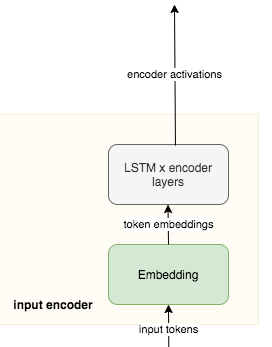

In [18]:
def input_encoder_fn(input_vocab_size, d_model, n_encoder_layers):
    """ Input encoder runs on the input sentence and creates
    activations that will be the keys and values for attention.
    
    Args:
        input_vocab_size: int: vocab size of the input
        d_model: int:  depth of embedding (n_units in the LSTM cell)
        n_encoder_layers: int: number of LSTM layers in the encoder
    Returns:
        tl.Serial: The input encoder
    """
    
    # create a serial network
    input_encoder = tl.Serial( 
        
        ### START CODE HERE (REPLACE INSTANCES OF `None` WITH YOUR CODE) ###
        # create an embedding layer to convert tokens to vectors
        tl.Embedding(vocab_size = input_vocab_size, d_feature = d_model),
        
        # feed the embeddings to the LSTM layers. It is a stack of n_encoder_layers LSTM layers
        [tl.LSTM(n_units = d_model) for _ in range(n_encoder_layers)]
        ### END CODE HERE ###
    )

    return input_encoder

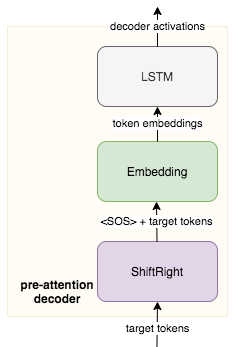

In [19]:
def pre_attention_decoder_fn(mode, target_vocab_size, d_model):
    """ Pre-attention decoder runs on the targets and creates
    activations that are used as queries in attention.
    
    Args:
        mode: str: 'train' or 'eval'
        target_vocab_size: int: vocab size of the target
        d_model: int:  depth of embedding (n_units in the LSTM cell)
    Returns:
        tl.Serial: The pre-attention decoder
    """
    
    # create a serial network
    pre_attention_decoder = tl.Serial(
        
        ### START CODE HERE (REPLACE INSTANCES OF `None` WITH YOUR CODE) ###
        # shift right to insert start-of-sentence token and implement
        # teacher forcing during training
        tl.ShiftRight(n_shifts=1, mode=mode),

        # run an embedding layer to convert tokens to vectors
        tl.Embedding(target_vocab_size, d_model),

        # feed to an LSTM layer
        tl.LSTM(d_model)
        ### END CODE HERE ###
    )
    
    return pre_attention_decoder

In [20]:
def prepare_attention_input(encoder_activations, decoder_activations, inputs):
    """Prepare queries, keys, values and mask for attention.
    
    Args:
        encoder_activations fastnp.array(batch_size, padded_input_length, d_model): output from the input encoder
        decoder_activations fastnp.array(batch_size, padded_input_length, d_model): output from the pre-attention decoder
        inputs fastnp.array(batch_size, padded_input_length): padded input tokens
    
    Returns:
        queries, keys, values and mask for attention.
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF `None` WITH YOUR CODE) ###
    
    # set the keys and values to the encoder activations
    keys = encoder_activations
    values = encoder_activations

    
    # set the queries to the decoder activations
    queries = decoder_activations
    
    # generate the mask to distinguish real tokens from padding
    # hint: inputs is 1 for real tokens and 0 where they are padding
    mask= inputs != 0
    
    ### END CODE HERE ###
    
    # add axes to the mask for attention heads and decoder length.
    mask = fastnp.reshape(mask, (mask.shape[0], 1, 1, mask.shape[1]))
    
    # broadcast so mask shape is [batch size, attention heads, decoder-len, encoder-len].
    # note: for this assignment, attention heads is set to 1.
    mask = mask + fastnp.zeros((1, 1, decoder_activations.shape[1], 1))
        
    
    return queries, keys, values, mask

## Implementation Overview

- sequence-to-sequence model with attention. This will be a Serial network and is illustrated in the diagram below.
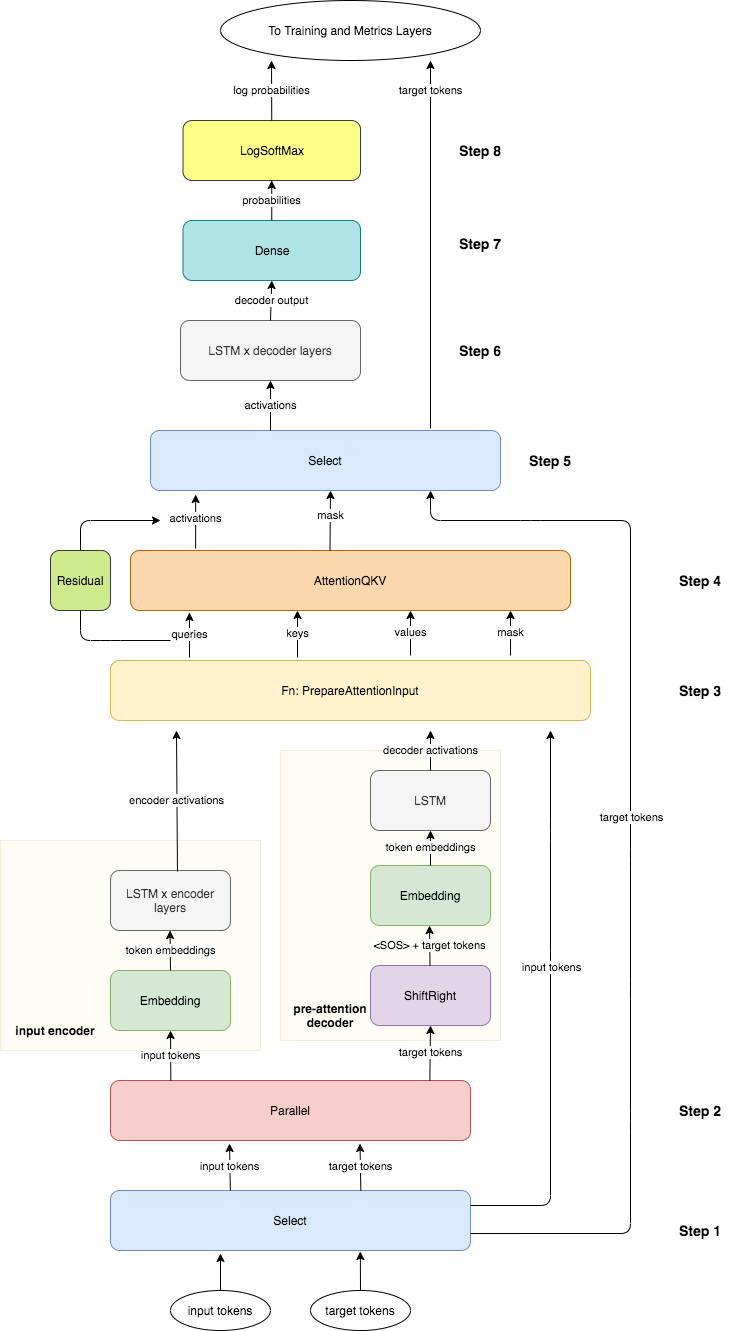

In [21]:
def NMTAttn(input_vocab_size=33300,
            target_vocab_size=33300,
            d_model=1024,
            n_encoder_layers=2,
            n_decoder_layers=2,
            n_attention_heads=4,
            attention_dropout=0.0,
            mode='train'):
    """Returns an LSTM sequence-to-sequence model with attention.

    The input to the model is a pair (input tokens, target tokens), e.g.,
    an English sentence (tokenized) and its translation into German (tokenized).

    Args:
    input_vocab_size: int: vocab size of the input
    target_vocab_size: int: vocab size of the target
    d_model: int:  depth of embedding (n_units in the LSTM cell)
    n_encoder_layers: int: number of LSTM layers in the encoder
    n_decoder_layers: int: number of LSTM layers in the decoder after attention
    n_attention_heads: int: number of attention heads
    attention_dropout: float, dropout for the attention layer
    mode: str: 'train', 'eval' or 'predict', predict mode is for fast inference

    Returns:
    A LSTM sequence-to-sequence model with attention.
    """

    ### START CODE HERE (REPLACE INSTANCES OF `None` WITH YOUR CODE) ###
    
    # Step 0: call the helper function to create layers for the input encoder
    input_encoder = input_encoder_fn(input_vocab_size, d_model, n_encoder_layers)

    # Step 0: call the helper function to create layers for the pre-attention decoder
    pre_attention_decoder = pre_attention_decoder_fn(mode, target_vocab_size, d_model)

    # Step 1: create a serial network
    model = tl.Serial( 
        
      # Step 2: copy input tokens and target tokens as they will be needed later.
      tl.Select([0,1,0,1]),
        
      # Step 3: run input encoder on the input and pre-attention decoder the target.
      tl.Parallel(input_encoder, pre_attention_decoder),
        
      # Step 4: prepare queries, keys, values and mask for attention.
      tl.Fn('PrepareAttentionInput', prepare_attention_input, n_out=4),
        
      # Step 5: run the AttentionQKV layer
      # nest it inside a Residual layer to add to the pre-attention decoder activations(i.e. queries)
      tl.Residual(tl.AttentionQKV(d_model, n_heads=n_attention_heads, dropout=attention_dropout, mode=mode)),
      
      # Step 6: drop attention mask (i.e. index = None
      tl.Select([0,2], n_in=3),
        
      # Step 7: run the rest of the RNN decoder
      [tl.LSTM(n_units = d_model) for _ in range(n_decoder_layers)],
        
      # Step 8: prepare output by making it the right size
      tl.Dense(target_vocab_size),
        
      # Step 9: Log-softmax for output
      tl.LogSoftmax()
    )
    
    ### END CODE HERE
    
    return model

In [22]:
# print your model
model = NMTAttn()
print(model)

Serial_in2_out2[
  Select[0,1,0,1]_in2_out4
  Parallel_in2_out2[
    Serial[
      Embedding_33300_1024
      LSTM_1024
      LSTM_1024
    ]
    Serial[
      ShiftRight(1)
      Embedding_33300_1024
      LSTM_1024
    ]
  ]
  PrepareAttentionInput_in3_out4
  Serial_in4_out2[
    Branch_in4_out3[
      None
      Serial_in4_out2[
        Parallel_in3_out3[
          Dense_1024
          Dense_1024
          Dense_1024
        ]
        PureAttention_in4_out2
        Dense_1024
      ]
    ]
    Add_in2
  ]
  Select[0,2]_in3_out2
  LSTM_1024
  LSTM_1024
  Dense_33300
  LogSoftmax
]


# Training
- The TrainTask class allows us to define the labeled data to use for training and the feedback mechanisms to compute the loss and update the weights.

In [23]:
train_task = training.TrainTask(
    
    ### START CODE HERE (REPLACE INSTANCES OF `None` WITH YOUR CODE) ###
    
    # use the train batch stream as labeled data
    labeled_data= train_batch_stream,
    
    # use the cross entropy loss
    loss_layer= tl.CrossEntropyLoss(),
    
    # use the Adam optimizer with learning rate of 0.01
    optimizer= trax.optimizers.Adam(0.01),
    
    # use the `trax.lr.warmup_and_rsqrt_decay` as the learning rate schedule
    # have 1000 warmup steps with a max value of 0.01
    lr_schedule= trax.lr.warmup_and_rsqrt_decay(1000, 0.01),
    
    # have a checkpoint every 10 steps
    n_steps_per_checkpoint= 10,
    
    ### END CODE HERE ###
)

In [24]:
eval_task = training.EvalTask(
    
    ## use the eval batch stream as labeled data
    labeled_data=eval_batch_stream,
    
    ## use the cross entropy loss and accuracy as metrics
    metrics=[tl.CrossEntropyLoss(), tl.Accuracy()],
)

The Loop class defines the model we will train as well as the train and eval tasks to execute. Its run() method allows us to execute the training for a specified number of steps

In [25]:
# define the output directory
output_dir = 'output_dir/'

# remove old model if it exists. restarts training.
!rm -f ~/output_dir/model.pkl.gz  

# define the training loop
training_loop = training.Loop(NMTAttn(mode='train'),
                              train_task,
                              eval_tasks=[eval_task],
                              output_dir=output_dir)

In [26]:
# NOTE: Execute the training loop.
training_loop.run(100)


Step      1: Ran 1 train steps in 79.05 secs
Step      1: train CrossEntropyLoss |  10.40127087
Step      1: eval  CrossEntropyLoss |  10.38144016
Step      1: eval          Accuracy |  0.00000000

Step     10: Ran 9 train steps in 108.27 secs
Step     10: train CrossEntropyLoss |  10.22572041
Step     10: eval  CrossEntropyLoss |  9.94177532
Step     10: eval          Accuracy |  0.02429765

Step     20: Ran 10 train steps in 85.27 secs
Step     20: train CrossEntropyLoss |  9.41692352
Step     20: eval  CrossEntropyLoss |  8.89921284
Step     20: eval          Accuracy |  0.01420679

Step     30: Ran 10 train steps in 99.34 secs
Step     30: train CrossEntropyLoss |  7.83167982
Step     30: eval  CrossEntropyLoss |  7.15352154
Step     30: eval          Accuracy |  0.04581245

Step     40: Ran 10 train steps in 89.77 secs
Step     40: train CrossEntropyLoss |  7.31788778
Step     40: eval  CrossEntropyLoss |  7.35434055
Step     40: eval          Accuracy |  0.02682927

Step     50:

# Test the model
- use training_loop.model in place of pretrained 'model' if required

In [24]:
# instantiate the model we built in eval mode
model = NMTAttn(mode='eval')

# initialize weights from a pre-trained model
model.init_from_file("model.pkl.gz", weights_only=False)
model = tl.Accelerate(model)

## Decoding
- "Next symbol" function: Gets next word using either Brute force or range of options based on temperature parameter
- "Sampling Decode" function calls the next_symbol() function several times until the next output is the end-of-sentence token (i.e. EOS). It takes in an input string and returns the translated version of that string

In [25]:
def next_symbol(NMTAttn, input_tokens, cur_output_tokens, temperature):
    """Returns the index of the next token.

    Args:
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        input_tokens (np.ndarray 1 x n_tokens): tokenized representation of the input sentence
        cur_output_tokens (list): tokenized representation of previously translated words
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)

    Returns:
        int: index of the next token in the translated sentence
        float: log probability of the next symbol
    """

    ### START CODE HERE (REPLACE INSTANCES OF `None` WITH YOUR CODE) ###

    # set the length of the current output tokens
    token_length = len(cur_output_tokens)

    # calculate next power of 2 for padding length 
    padded_length = int(2**np.ceil(np.log2(token_length+1)))

    # pad cur_output_tokens up to the padded_length
    padded = cur_output_tokens + [0] * padded_length #(padded_length-token_length)
    
    # model expects the output to have an axis for the batch size in front so
    # convert `padded` list to a numpy array with shape (x, <padded_length>) where the
    # x position is the batch axis. (hint: you can use np.expand_dims() with axis=0 to insert a new axis)
    padded_with_batch = np.expand_dims(np.array(padded), axis=0)

    # get the model prediction. remember to use the `NMTAttn` argument defined above.
    # hint: the model accepts a tuple as input (e.g. `my_model((input1, input2))`)
    output, _ = NMTAttn((input_tokens, padded_with_batch))
    
    # get log probabilities from the last token output
    log_probs = output[1, token_length, :]

    # get the next symbol by getting a logsoftmax sample (*hint: cast to an int)
    symbol = int(tl.logsoftmax_sample(log_probs, temperature))
    
    ### END CODE HERE ###

    return symbol, float(log_probs[symbol])


In [26]:
def sampling_decode(input_sentence, NMTAttn = None, temperature=0.0, vocab_file=None, vocab_dir=None):
    """Returns the translated sentence.

    Args:
        input_sentence (str): sentence to translate.
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)
        vocab_file (str): filename of the vocabulary
        vocab_dir (str): path to the vocabulary file

    Returns:
        tuple: (list, str, float)
            list of int: tokenized version of the translated sentence
            float: log probability of the translated sentence
            str: the translated sentence
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF `None` WITH YOUR CODE) ###
    
    # encode the input sentence
    input_tokens = tokenize(input_sentence, vocab_file=vocab_file, vocab_dir=vocab_dir)
    
    # initialize the list of output tokens
    cur_output_tokens = []
    
    # initialize an integer that represents the current output index
    cur_output = 0
    
    # Set the encoding of the "end of sentence" as 1
    EOS = 1
    
    # check that the current output is not the end of sentence token
    while cur_output != EOS:
        
        # update the current output token by getting the index of the next word (hint: use next_symbol)
        cur_output, log_prob = next_symbol(NMTAttn, input_tokens, cur_output_tokens, temperature)
        
        # append the current output token to the list of output tokens
        cur_output_tokens.append(cur_output)
    
    # detokenize the output tokens
    sentence = detokenize(cur_output_tokens, vocab_file=vocab_file, vocab_dir=vocab_dir)
    
    ### END CODE HERE ###
    
    return cur_output_tokens, log_prob, sentence

In [27]:
# Test the function above. Try varying the temperature setting with values from 0 to 1.
# Run it several times with each setting and see how often the output changes.
sampling_decode("I love languages.", model, temperature=0.0, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)

([161, 12202, 5112, 3, 1], -0.0001735687255859375, 'Ich liebe Sprachen.')

In [28]:
def greedy_decode_test(sentence, NMTAttn=None, vocab_file=None, vocab_dir=None):
    """Prints the input and output of our NMTAttn model using greedy decode

    Args:
        sentence (str): a custom string.
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        vocab_file (str): filename of the vocabulary
        vocab_dir (str): path to the vocabulary file

    Returns:
        str: the translated sentence
    """
    
    _,_, translated_sentence = sampling_decode(sentence, NMTAttn, vocab_file=vocab_file, vocab_dir=vocab_dir)
    
    print("English: ", sentence)
    print("German: ", translated_sentence)
    
    return translated_sentence

In [29]:
# put a custom string here
your_sentence = 'I love languages.'

greedy_decode_test(your_sentence, model, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR);

English:  I love languages.
German:  Ich liebe Sprachen.


In [30]:
greedy_decode_test('You are almost done with the assignment!', model, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR);

English:  You are almost done with the assignment!
German:  Sie sind fast mit der Aufgabe fertig!


## Minimum Bayes-Risk Decoding or MBR
getting the most probable token at each step may not necessarily produce the best results. Another approach is to do Minimum Bayes Risk Decoding or MBR. The general steps to implement this are:

- take several random samples
- score each sample against all other samples
- select the one with the highest score

In [31]:
def generate_samples(sentence, n_samples, NMTAttn=None, temperature=0.6, vocab_file=None, vocab_dir=None):
    """Generates samples using sampling_decode()

    Args:
        sentence (str): sentence to translate.
        n_samples (int): number of samples to generate
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)
        vocab_file (str): filename of the vocabulary
        vocab_dir (str): path to the vocabulary file
        
    Returns:
        tuple: (list, list)
            list of lists: token list per sample
            list of floats: log probability per sample
    """
    # define lists to contain samples and probabilities
    samples, log_probs = [], []

    # run a for loop to generate n samples
    for _ in range(n_samples):
        
        # get a sample using the sampling_decode() function
        sample, logp, _ = sampling_decode(sentence, NMTAttn, temperature, vocab_file=vocab_file, vocab_dir=vocab_dir)
        
        # append the token list to the samples list
        samples.append(sample)
        
        # append the log probability to the log_probs list
        log_probs.append(logp)
                
    return samples, log_probs

In [32]:
# generate 4 samples with the default temperature (0.6)
generate_samples('I love languages.', 4, model, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)

([[161, 12202, 5112, 3, 1],
  [161, 12202, 5112, 3, 1],
  [161, 12202, 5112, 3, 1],
  [161, 12202, 5112, 3, 1]],
 [-0.0001735687255859375,
  -0.0001735687255859375,
  -0.0001735687255859375,
  -0.0001735687255859375])

### Similarity measures

In [33]:
def jaccard_similarity(candidate, reference):
    """Returns the Jaccard similarity between two token lists

    Args:
        candidate (list of int): tokenized version of the candidate translation
        reference (list of int): tokenized version of the reference translation

    Returns:
        float: overlap between the two token lists
    """
    
    # convert the lists to a set to get the unique tokens
    can_unigram_set, ref_unigram_set = set(candidate), set(reference)  
    
    # get the set of tokens common to both candidate and reference
    joint_elems = can_unigram_set.intersection(ref_unigram_set)
    
    # get the set of all tokens found in either candidate or reference
    all_elems = can_unigram_set.union(ref_unigram_set)
    
    # divide the number of joint elements by the number of all elements
    overlap = len(joint_elems) / len(all_elems)
    
    return overlap

In [34]:
def rouge1_similarity(system, reference):
    """Returns the ROUGE-1 score between two token lists

    Args:
        system (list of int): tokenized version of the system translation
        reference (list of int): tokenized version of the reference translation

    Returns:
        float: overlap between the two token lists
    """    
    
    ### START CODE HERE (REPLACE INSTANCES OF `None` WITH YOUR CODE) ###
    
    # make a frequency table of the system tokens (hint: use the Counter class)
    sys_counter = Counter(system)
    
    # make a frequency table of the reference tokens (hint: use the Counter class)
    ref_counter = Counter(reference)
    
    # initialize overlap to 0
    overlap = 0
    
    # run a for loop over the sys_counter object (can be treated as a dictionary)
    for token in sys_counter:
        
        # lookup the value of the token in the sys_counter dictionary (hint: use the get() method)
        token_count_sys = sys_counter.get(token, 0)
        
        # lookup the value of the token in the ref_counter dictionary (hint: use the get() method)
        token_count_ref = ref_counter.get(token, 0)

        # update the overlap by getting the smaller number between the two token counts above
        overlap += min(token_count_sys,token_count_ref)
    
    # get the precision (i.e. number of overlapping tokens / number of system tokens)
    precision = overlap / len(system)
    
    # get the recall (i.e. number of overlapping tokens / number of reference tokens)
    recall = overlap / len(reference)
    
    if precision + recall != 0:
        # compute the f1-score
        rouge1_score = 2 * (precision * recall) / (precision + recall)
    else:
        rouge1_score = 0 
    ### END CODE HERE ###
    
    return rouge1_score

In [35]:
def average_overlap(similarity_fn, samples, *ignore_params):
    """Returns the arithmetic mean of each candidate sentence in the samples

    Args:
        similarity_fn (function): similarity function used to compute the overlap
        samples (list of lists): tokenized version of the translated sentences
        *ignore_params: additional parameters will be ignored

    Returns:
        dict: scores of each sample
            key: index of the sample
            value: score of the sample
    """  
    
    # initialize dictionary
    scores = {}
    
    # run a for loop for each sample
    for index_candidate, candidate in enumerate(samples):    
        
        ### START CODE HERE (REPLACE INSTANCES OF `None` WITH YOUR CODE) ###
        
        # initialize overlap to 0.0
        overlap = 0
        
        # run a for loop for each sample
        for index_sample, sample in enumerate(samples): 

            # skip if the candidate index is the same as the sample index
            if index_candidate == index_sample:
                continue
                
            # get the overlap between candidate and sample using the similarity function
            sample_overlap = similarity_fn(candidate, sample)
            
            # add the sample overlap to the total overlap
            overlap += sample_overlap
            
        # get the score for the candidate by computing the average
        score = overlap / (len(samples) - 1)
        
        # save the score in the dictionary. use index as the key.
        scores[index_candidate] = score
        
        ### END CODE HERE ###
    return scores

In [36]:
def weighted_avg_overlap(similarity_fn, samples, log_probs):
    """Returns the weighted mean of each candidate sentence in the samples

    Args:
        samples (list of lists): tokenized version of the translated sentences
        log_probs (list of float): log probability of the translated sentences

    Returns:
        dict: scores of each sample
            key: index of the sample
            value: score of the sample
    """
    
    # initialize dictionary
    scores = {}
    
    # run a for loop for each sample
    for index_candidate, candidate in enumerate(samples):    
        
        # initialize overlap and weighted sum
        overlap, weight_sum = 0.0, 0.0
        
        # run a for loop for each sample
        for index_sample, (sample, logp) in enumerate(zip(samples, log_probs)):

            # skip if the candidate index is the same as the sample index            
            if index_candidate == index_sample:
                continue
                
            # convert log probability to linear scale
            sample_p = float(np.exp(logp))

            # update the weighted sum
            weight_sum += sample_p

            # get the unigram overlap between candidate and sample
            sample_overlap = similarity_fn(candidate, sample)
            
            # update the overlap
            overlap += sample_p * sample_overlap
            
        # get the score for the candidate
        score = overlap / weight_sum
        
        # save the score in the dictionary. use index as the key.
        scores[index_candidate] = score
    
    return scores

#### generate samples, get the score for each sample, get the highest score among all samples, then detokenize this sample to get the translated sentence usign MBR

In [37]:
def mbr_decode(sentence, n_samples, score_fn, similarity_fn, NMTAttn=None, temperature=0.6, vocab_file=None, vocab_dir=None):
    """Returns the translated sentence using Minimum Bayes Risk decoding

    Args:
        sentence (str): sentence to translate.
        n_samples (int): number of samples to generate
        score_fn (function): function that generates the score for each sample
        similarity_fn (function): function used to compute the overlap between a pair of samples
        NMTAttn (tl.Serial): An LSTM sequence-to-sequence model with attention.
        temperature (float): parameter for sampling ranging from 0.0 to 1.0.
            0.0: same as argmax, always pick the most probable token
            1.0: sampling from the distribution (can sometimes say random things)
        vocab_file (str): filename of the vocabulary
        vocab_dir (str): path to the vocabulary file

    Returns:
        str: the translated sentence
    """
    
    ### START CODE HERE (REPLACE INSTANCES OF `None` WITH YOUR CODE) ###
    # generate samples
    samples, log_probs = generate_samples(sentence, n_samples, NMTAttn, temperature, vocab_file, vocab_dir)
    
    # use the scoring function to get a dictionary of scores
    # pass in the relevant parameters as shown in the function definition of 
    # the mean methods you developed earlier
    scores = score_fn(similarity_fn, samples, log_probs)
    
    # find the key with the highest score
    max_index = max(scores)
    
    # detokenize the token list associated with the max_index
    translated_sentence = detokenize(samples[max_index], vocab_file, vocab_dir)
    
    ### END CODE HERE ###
    return (translated_sentence, max_index, scores)

In [55]:
TEMPERATURE = 0.6

# put a custom string here
your_sentence = 'She speaks English and German.'

In [56]:
print(your_sentence)
print(colored('translation: ', 'red'), mbr_decode(your_sentence, 4, weighted_avg_overlap, jaccard_similarity, model, TEMPERATURE, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)[0])

She speaks English and German.
translation:  Sie spricht Englisch und Deutsch.


In [50]:
your_sentence = 'Congratulations!'
print(your_sentence)
print(colored('translation: ', 'red'), mbr_decode(your_sentence, 4, average_overlap, rouge1_similarity, model, TEMPERATURE, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)[0])

Congratulations!
translation:  Herzlichen Glückwunsch!


In [47]:
your_sentence = 'You have completed the assignment!'
print(your_sentence)
print(colored('translation: ', 'red'), mbr_decode(your_sentence, 4, average_overlap, rouge1_similarity, model, TEMPERATURE, vocab_file=VOCAB_FILE, vocab_dir=VOCAB_DIR)[0])

You have completed the assignment!
translation:  Sie haben die Bestellung abgeschlossen!
